# Toy GPyTorch

https://docs.gpytorch.ai/en/stable/

Imports

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import timeit

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data we want to learn

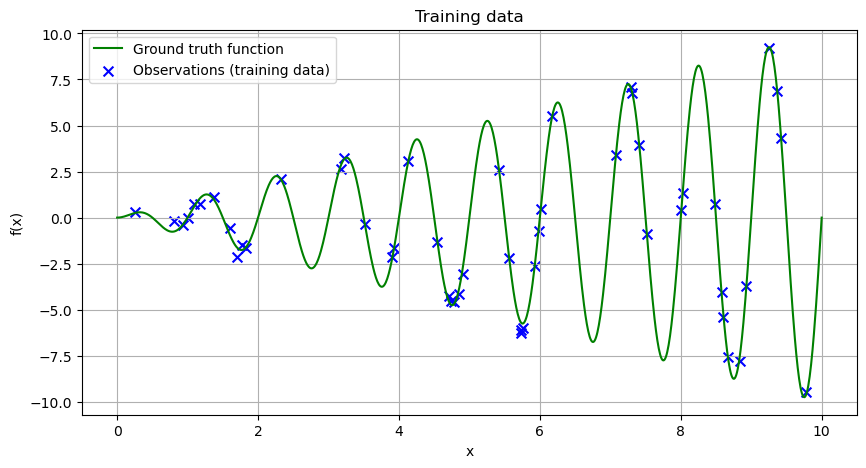

In [60]:
N = 1000

# X's
Xs = torch.linspace(0, 10, N).view(-1, 1)

# function f
def f(x):
    return x * torch.sin(x * (2 * math.pi))

# ground truth function values
fs = f(Xs)

# noisy observations
NOISE = 0.05  # sigma^2
ys = fs + torch.randn(fs.size()) * math.sqrt(NOISE)

# training data
N_SAMPLES = 50
idx = torch.randperm(N)[:N_SAMPLES]  # random indices for training data
Xs_train = Xs[idx]
ys_train = ys[idx]

# plot data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(Xs.numpy(), fs.numpy(), 'green', label='Ground truth function')
ax.scatter(Xs_train.numpy(), ys_train.numpy(), marker='x', c='b', label='Observations (training data)', s=50)
ax.set_title('Training data')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()
ax.grid()
plt.show()

## Gaussian Process Model

In [61]:
# We will use the simplest form of GP model, exact inference

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        
        """An __init__ method that takes the training data and a likelihood, 
        and constructs whatever objects are necessary for the model"s forward method. 
        This will most commonly include things like a mean module and a kernel module.
        """
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # constant mean as prior mean
        self.mean_module = gpytorch.means.ConstantMean()
        # RBF kernel as prior covariance
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        """A forward method that takes in some n x d data x and returns a MultivariateNormal with the prior mean and covariance evaluated at x. 
        In other words, we return the vector mu(x) and the n x n matrix representing the prior mean and covariance matrix of the GP.
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Going to GPU

In [62]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


In [63]:
# Go to GPU when available

if torch.cuda.is_available():
    print(f"Going to GPU")
    Xs_train = Xs_train.squeeze().cuda()  # remove the extra dimension to get tensor sizes (N)
    ys_train = ys_train.squeeze().cuda()
    Xs = Xs.squeeze().cuda()  # remove the extra dimension to get tensor sizes (N)

Going to GPU


In [64]:
print(f"Xs: {Xs.size()}, Xs_train: {Xs_train.size()}, ys_train: {ys_train.size()}")

Xs: torch.Size([1000]), Xs_train: torch.Size([50]), ys_train: torch.Size([50])


## Training

In [65]:
# Choose the likelihood
# https://docs.gpytorch.ai/en/stable/likelihoods.html

# when given a MultivariateNormal distribution f(x) as input,
# the likelihood will return the marginal distribution p(y | f(x))

# here we assume a Guassian likelihood, ie y = f(x) + \epsilon, with \epsilon ~ N(0, sigma^2)
# the noise is assumed to be the same on all observations,
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [66]:
# initialize the model and the likelihood
# the model is instantiated with the N observations, 
# the GP prior (mean and covariance), 
# and the likelihood
model = ExactGPModel(Xs_train, ys_train, likelihood)

In [67]:
model = model.cuda()
likelihood = likelihood.cuda()

In [68]:
output = model(Xs_train)

print(f"output type: {type(output)}")
print(f"output mean: {output.mean.size()}")
print(f"output covariance: {output.covariance_matrix.size()}")

output type: <class 'gpytorch.distributions.multivariate_normal.MultivariateNormal'>
output mean: torch.Size([50])
output covariance: torch.Size([50, 50])


In [69]:
model.train()  # set the model to training mode
likelihood.train()  # set the likelihood to training mode

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

Iter 1 - Loss: 9.216


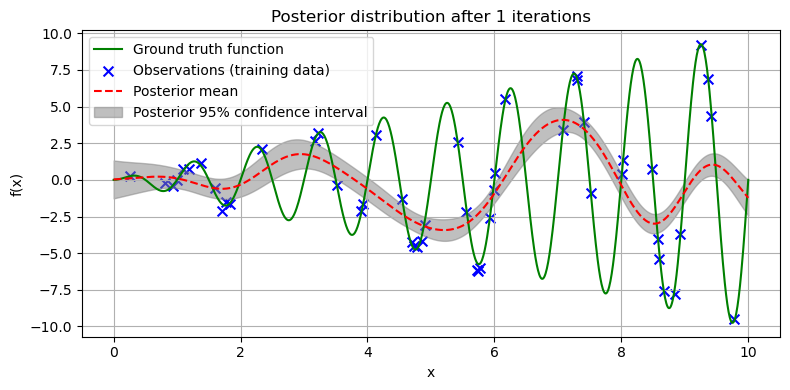

Iter 26 - Loss: 2.848


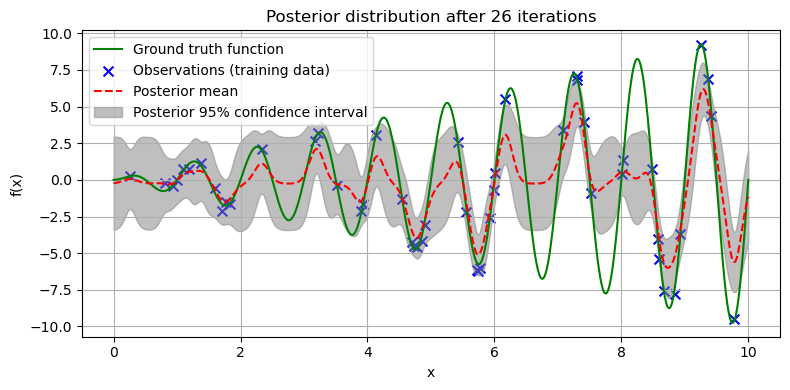

Iter 51 - Loss: 2.593


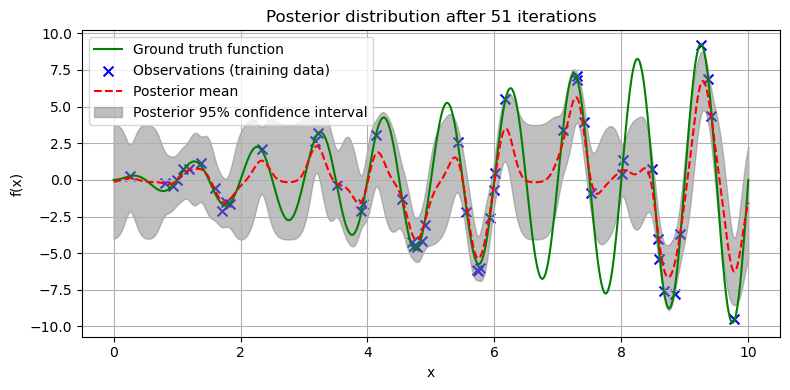

Iter 76 - Loss: 2.491


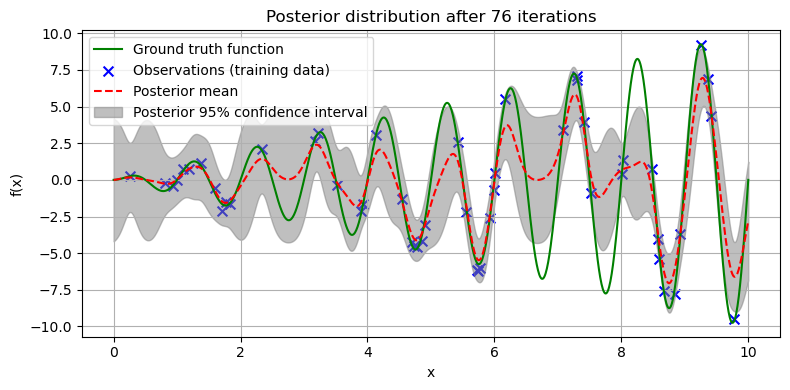

Iter 101 - Loss: 2.441


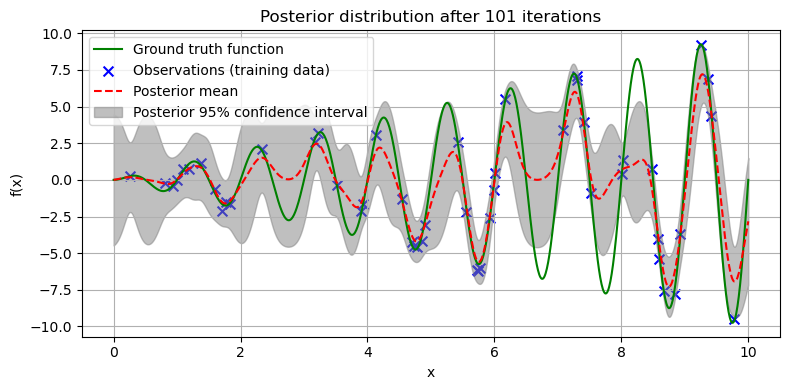

Iter 126 - Loss: 2.403


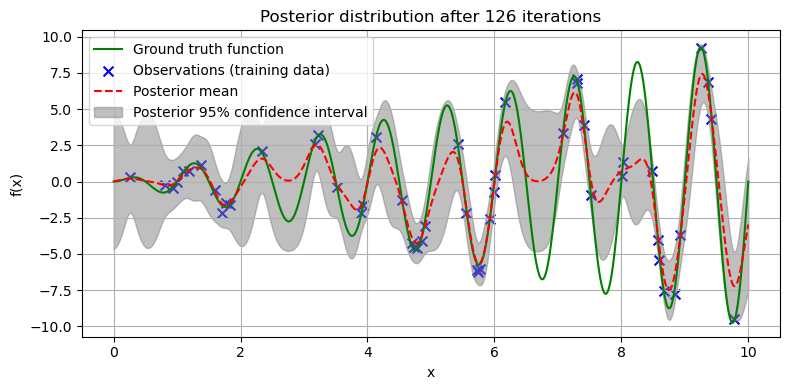

Iter 151 - Loss: 2.368


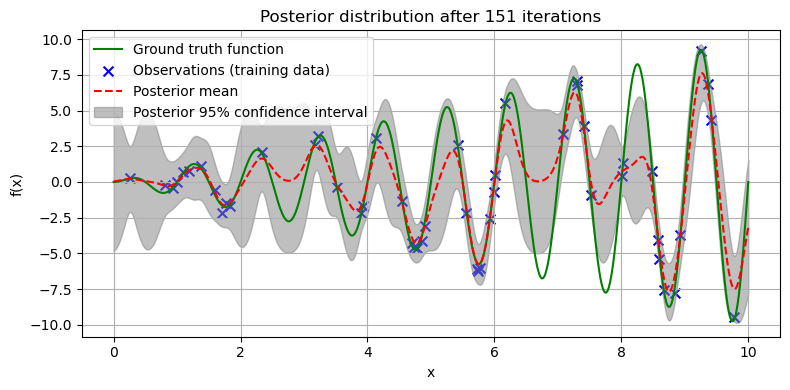

Iter 176 - Loss: 2.335


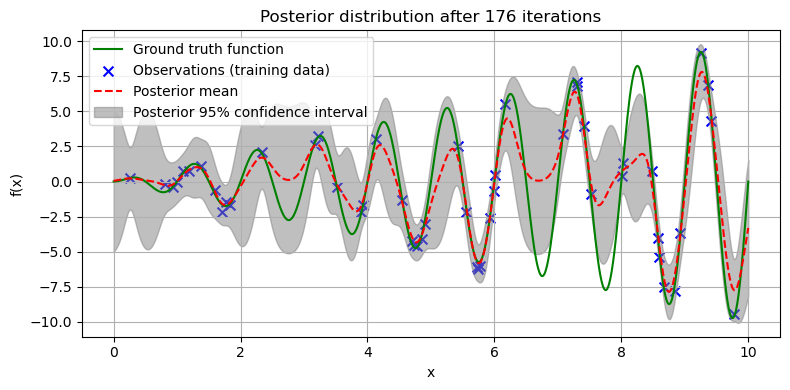

Iter 201 - Loss: 2.299


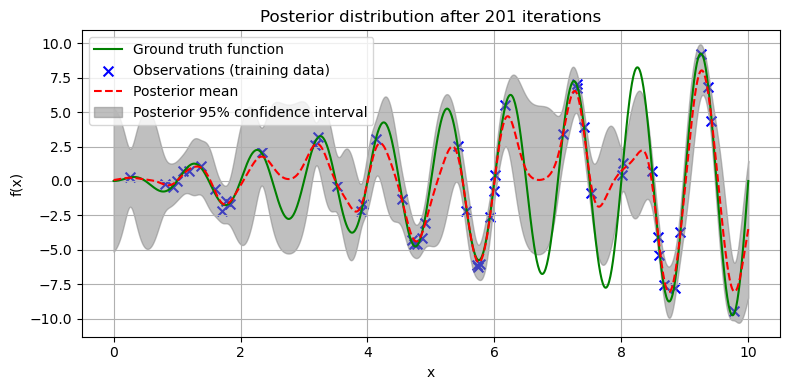

Iter 226 - Loss: 2.258


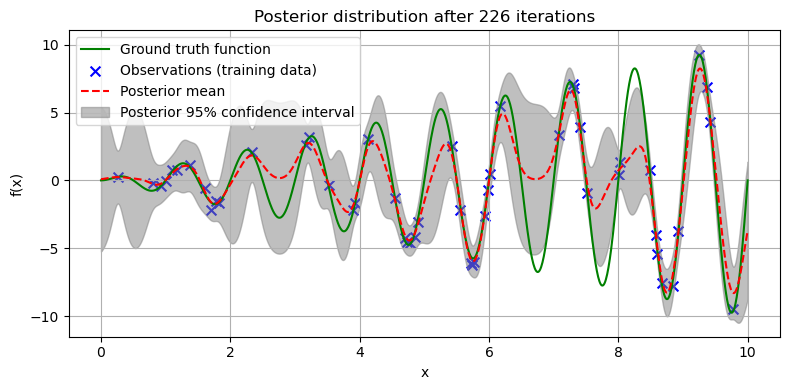

Iter 251 - Loss: 2.211


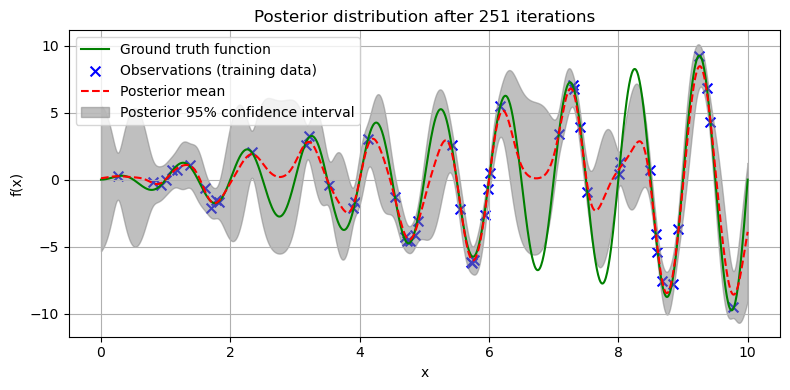

Iter 276 - Loss: 2.155


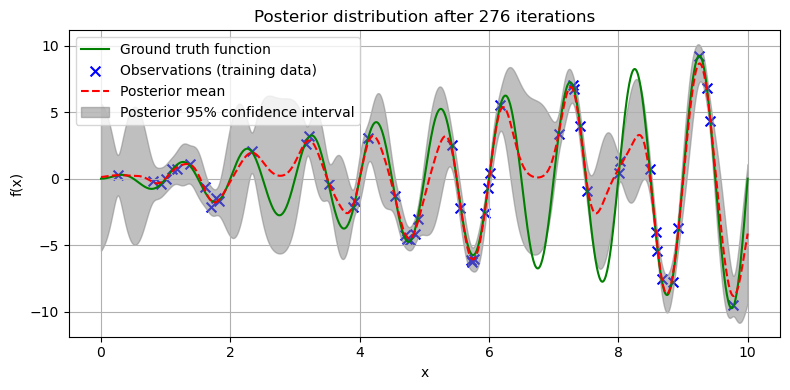

Iter 301 - Loss: 2.091


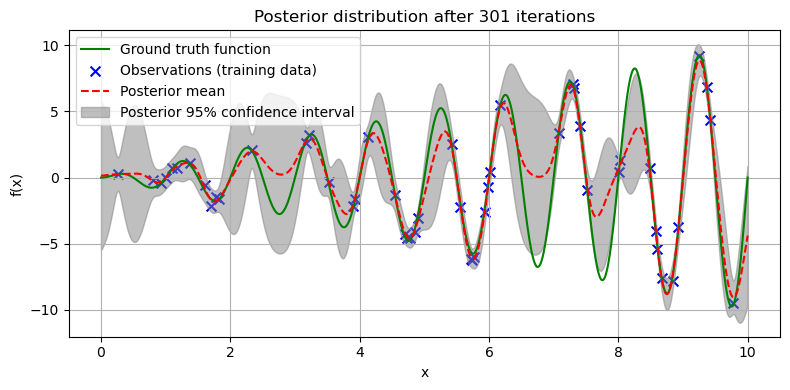

Iter 326 - Loss: 2.024


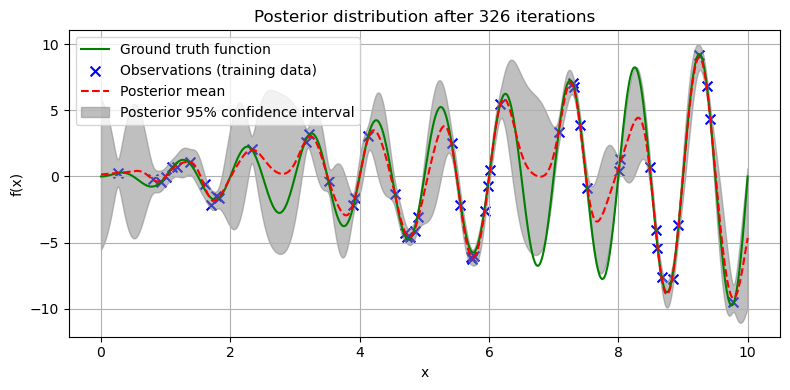

Iter 351 - Loss: 1.961


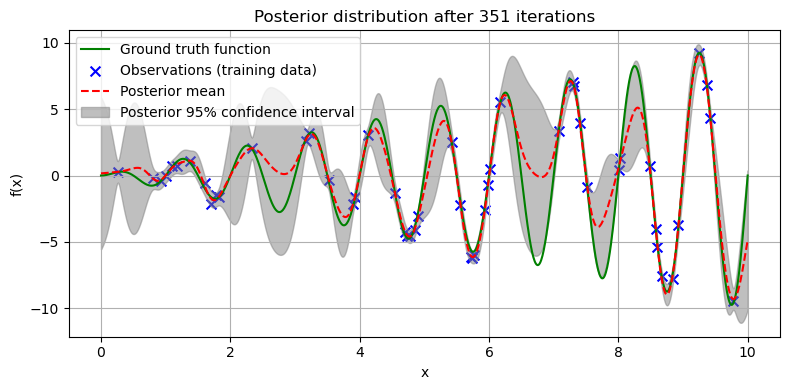

Iter 376 - Loss: 1.912


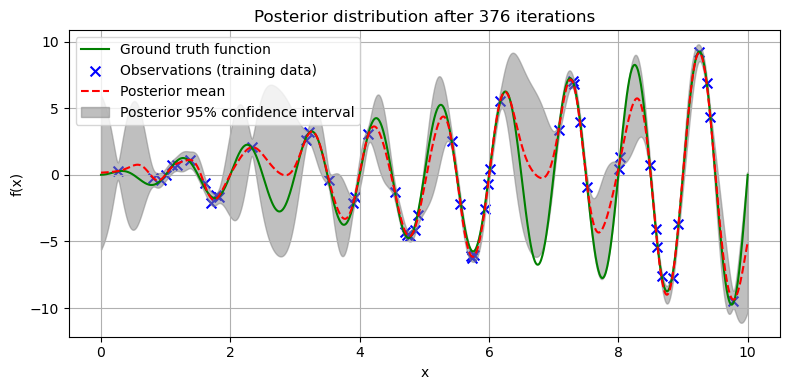

In [70]:
# loops between display of results
iterations_between_displays = 25

# threshold for change in loss between two iterations
thresold = 1e-3
max_iters = 1000  # maximum number of iterations

# Training loop
decrease = torch.tensor([float('inf')], device=device)  # initialize decrease to infinity
i = 0
    
while decrease >= thresold and i < max_iters:
    
    # training mode
    model.train()
    likelihood.train()
    
    # reset gradients to zero as usual
    optimizer.zero_grad()
    
    # output from model
    # this returns a MultivariateNormal distribution N( m(x_train), K(x_train, x_train) ) on the training data
    output = model(Xs_train)
    
    # compute loss
    # mll is the marginal log likelihood
    # of the data ys_train given the MV Normal distribution 
    # returned by the model on the training data Xs_train
    loss = -mll(output, ys_train)
    
    # gradient descent step
    loss.backward()
    optimizer.step()
    
    # compute decrease in loss
    if i >= 1:
        decrease = torch.abs(torch.tensor(prev_loss - loss.item()))
        prev_loss = loss.item()
    else:
        prev_loss = loss.item()
    
    # display posterior distribution
    if i % iterations_between_displays == 0:
        
        # print the loss
        print(f"Iter {i + 1} - Loss: {loss.item():.3f}")
        
        model.eval()  # set the model to evaluation mode
        likelihood.eval()
        
        with torch.no_grad():
            # get posterior distribution on a set of test points
            posterior = model(Xs)
            
            # get posterior mean and covariance
            posterior_mean = posterior.mean
            posterior_covariance = posterior.covariance_matrix
            
            # plot the posterior distribution
            fig, ax = plt.subplots(1, 1, figsize=(8, 4))
            ax.plot(Xs.cpu().numpy(), fs.cpu().numpy(), c='green', label='Ground truth function')
            ax.scatter(Xs_train.cpu().numpy(), ys_train.cpu().numpy(), c='b', marker='x', label='Observations (training data)', s=50)
            ax.plot(Xs.cpu().numpy(), posterior_mean.cpu().numpy(), 'r', linestyle='--', label='Posterior mean')
            ax.fill_between(Xs.cpu().numpy().flatten(),
                            (posterior_mean - 2 * torch.sqrt(posterior_covariance.diagonal())).cpu().numpy(),
                            (posterior_mean + 2 * torch.sqrt(posterior_covariance.diagonal())).cpu().numpy(),
                            color='gray', alpha=0.5, label='Posterior 95% confidence interval')
            ax.set_title(f'Posterior distribution after {i+1} iterations')
            ax.set_xlabel('x')
            ax.set_ylabel('f(x)')
            ax.legend()
            ax.grid()
            plt.tight_layout()
            plt.show()
            
    i += 1